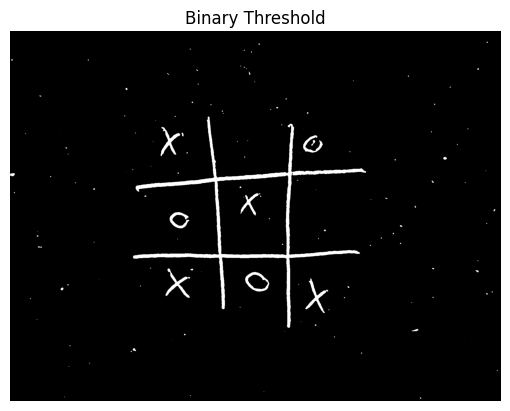

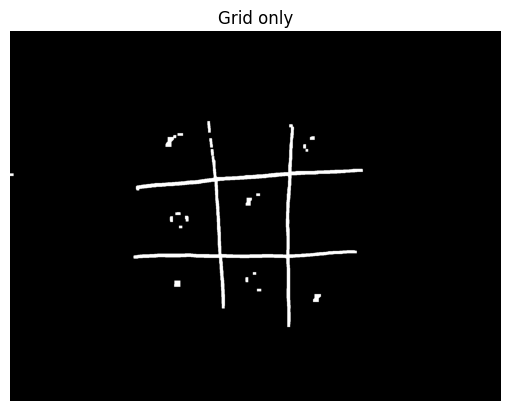

Warnung: Keine Linien gefunden, kontur-basiertes Zuschneiden


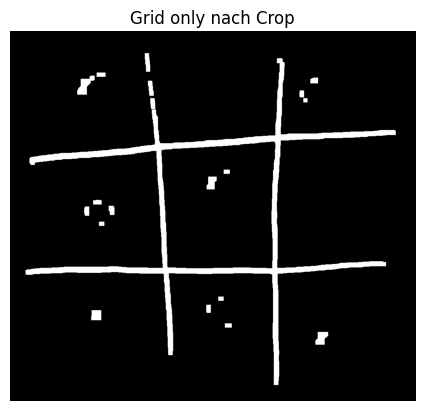

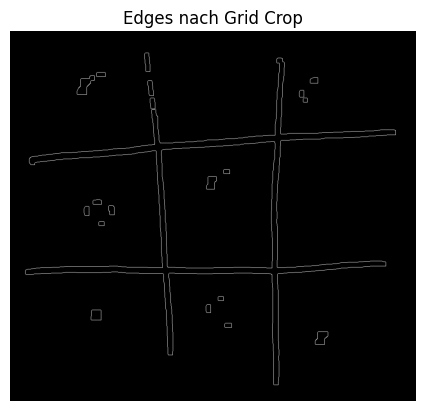

Gefundene Linien (roh): 121
Gefundene Linien (gefiltert): 12


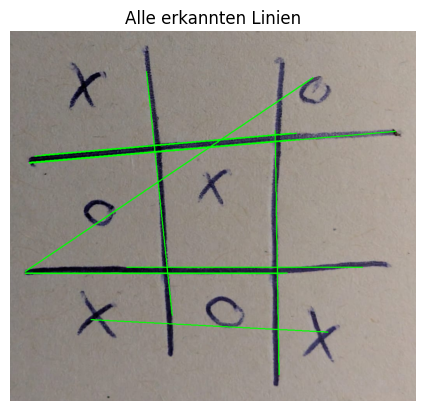

x-ungeclustert: [np.int32(384), np.int32(687)]
x-geclustert: [384, 687]
y-ungeclustert: [np.int32(299), np.int32(309), np.int32(292), np.int32(309), np.int32(623), np.int32(624), np.int32(291), np.int32(759), np.int32(608)]
y-geclustert: [300, 608, 623, 759]


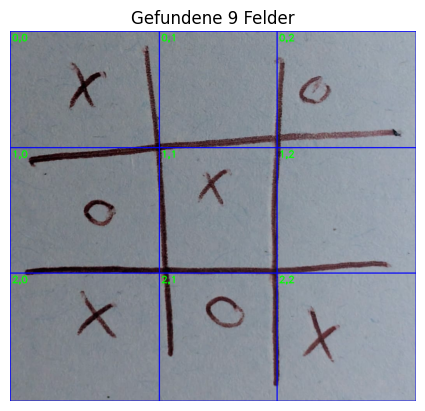

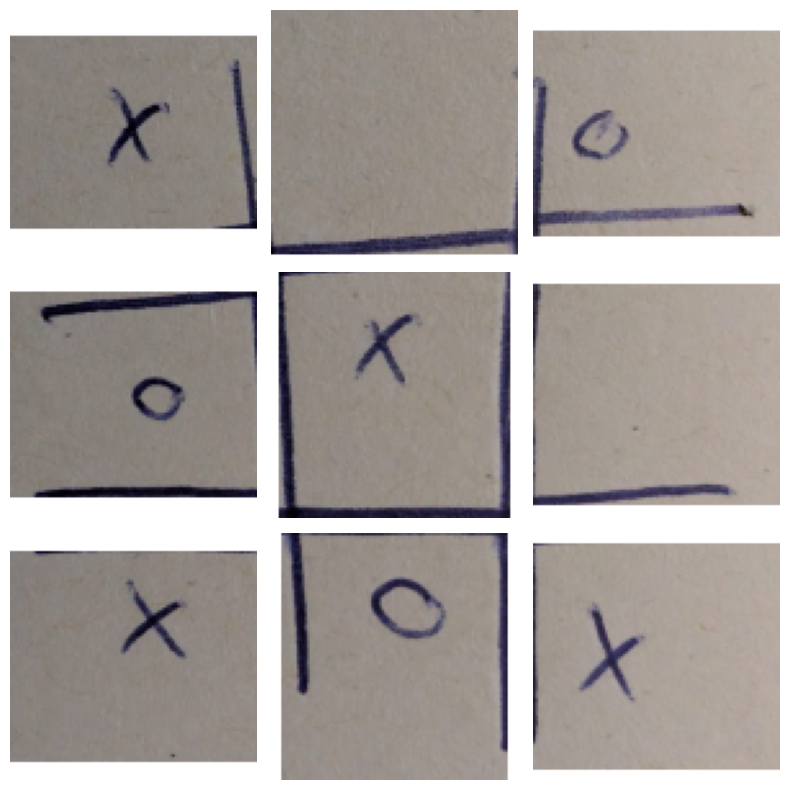

In [36]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import color

def show_image(image, title=None):
    plt.imshow(image, cmap='gray')
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

def cluster_coords(coords, mindist=20):
    if not coords:
        return []
    coords = sorted(coords)
    clustered = []
    current = [coords[0]]
    for c in coords[1:]:
        if abs(c - current[-1]) < mindist:
            current.append(c)
        else:
            clustered.append(int(np.mean(current)))
            current = [c]
    clustered.append(int(np.mean(current)))
    return clustered

def get_two_most_centered(coords, img_size):
    if len(coords) < 2:
        return None
    targets = [img_size//3, 2*img_size//3]
    selected = []
    coords = sorted(coords)
    for t in targets:
        best = min(coords, key=lambda c: abs(c - t))
        selected.append(best)
        coords.remove(best)
    return sorted(selected)

def get_line_centers(lines, img_size, axis='x'):
    coords = []
    if lines is not None:
        for l in lines:
            x1,y1,x2,y2 = l[0]
            if axis=='x' and abs(x1-x2) < img_size*0.15:
                coords.append((x1+x2)//2)
            if axis=='y' and abs(y1-y2) < img_size*0.15:
                coords.append((y1+y2)//2)
    mind = 15 if axis=='y' else int(img_size*0.04)
    clustered = cluster_coords(coords, mindist=mind)
    print(f"{axis}-ungeclustert:", coords)
    print(f"{axis}-geclustert:", clustered)
    return clustered

def filter_longest_lines(lines, num=12):
    if lines is None or len(lines)==0:
        return []
    segs = [l[0] for l in lines]
    segs.sort(key=lambda l:(l[2]-l[0])**2+(l[3]-l[1])**2, reverse=True)
    return np.array([[s] for s in segs[:num]])

def crop_to_largest_contour(binary, img):
    contours, _ = cv2.findContours(binary, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return binary, img
    x,y,w,h = cv2.boundingRect(max(contours, key=cv2.contourArea))
    pad = int(0.04 * max(w,h))
    x,y = max(0,x-pad), max(0,y-pad)
    w,h = min(binary.shape[1]-x, w+2*pad), min(binary.shape[0]-y, h+2*pad)
    return binary[y:y+h, x:x+w], img[y:y+h, x:x+w]

def detect_tic_tac_toe_grid(img_path):
    img_orig = cv2.imread(img_path)
    gray = cv2.cvtColor(img_orig, cv2.COLOR_BGR2GRAY)
    blur = cv2.medianBlur(gray, 7)

    # adaptive threshold
    binary = cv2.adaptiveThreshold(
        blur, 255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        cv2.THRESH_BINARY_INV,
        blockSize=51, C=7
    )
    show_image(binary, "Binary Threshold")

    # extract grid mask
    kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (11,11))
    grid_only = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
    grid_only = cv2.morphologyEx(grid_only, cv2.MORPH_OPEN, kernel)
    show_image(grid_only, "Grid only")

    # detect strong grid lines
    edges_grid = cv2.Canny(grid_only, 20, 70, apertureSize=3)
    h, w = grid_only.shape
    L = int(min(h,w) * 0.5)
    lines = cv2.HoughLinesP(
        edges_grid, 1, np.pi/180,
        threshold=20, minLineLength=L, maxLineGap=20
    )

    # if no lines found, fallback to contour-crop
    if lines is None or len(lines) == 0:
        print("Warnung: Keine Linien gefunden, kontur-basiertes Zuschneiden")
        binary, img_cropped = crop_to_largest_contour(binary, img_orig)
        grid_only = cv2.morphologyEx(binary, cv2.MORPH_CLOSE, kernel)
        grid_only = cv2.morphologyEx(grid_only, cv2.MORPH_OPEN, kernel)
        img = img_cropped
    else:
        # split vertical/horizontal segments
        verts = [l[0] for l in lines if abs(l[0][0] - l[0][2]) < 5]
        hors  = [l[0] for l in lines if abs(l[0][1] - l[0][3]) < 5]

        # get two inner grid coords
        xs = sorted((x1+x2)//2 for x1,y1,x2,y2 in verts)
        ys = sorted((y1+y2)//2 for x1,y1,x2,y2 in hors)
        xs = get_two_most_centered(xs, w)
        ys = get_two_most_centered(ys, h)

        # build boundaries
        x_coords = [0] + xs + [w]
        y_coords = [0] + ys + [h]

        # perform cropping
        x1, x2 = x_coords[0], x_coords[-1]
        y1, y2 = y_coords[0], y_coords[-1]
        img = img_orig[y1:y2, x1:x2]
        binary = binary[y1:y2, x1:x2]
        grid_only = grid_only[y1:y2, x1:x2]

    show_image(grid_only, "Grid only nach Crop")

    # now standard field extraction
    edges = cv2.Canny(grid_only, 20, 70, apertureSize=3)
    show_image(edges, "Edges nach Grid Crop")

    h, w = grid_only.shape
    min_dim = min(h,w)
    minL = int(min_dim*0.1)
    maxG= int(min_dim*0.25)

    lines = cv2.HoughLinesP(
        edges, 1, np.pi/180,
        threshold=10, minLineLength=minL, maxLineGap=maxG
    )
    print("Gefundene Linien (roh):", len(lines) if lines is not None else 0)
    lines = filter_longest_lines(lines, num=12)
    print("Gefundene Linien (gefiltert):", len(lines))

    if lines is not None and len(lines):
        dbg = img.copy()
        for l in lines:
            x1,y1,x2,y2 = l[0]
            cv2.line(dbg, (x1,y1), (x2,y2), (0,255,0), 2)
        show_image(cv2.cvtColor(dbg, cv2.COLOR_BGR2RGB), "Alle erkannten Linien")

    x_centers = get_line_centers(lines, w, axis='x')
    y_centers = get_line_centers(lines, h, axis='y')
    vx = get_two_most_centered(x_centers, w)
    hy = get_two_most_centered(y_centers, h)

    x_coords = [0] + vx + [w]
    y_coords = [0] + hy + [h]

    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img_grid = img_rgb.copy()
    field_bilder, positionen = [], []

    for row in range(3):
        for col in range(3):
            xa, xb = x_coords[col], x_coords[col+1]
            ya, yb = y_coords[row], y_coords[row+1]
            feld = img[ya:yb, xa:xb]
            field_bilder.append(feld)
            positionen.append((row, col))
            cv2.rectangle(img_grid, (xa,ya), (xb,yb), (255,0,0), 2)
            cv2.putText(img_grid, f"{row},{col}", (xa+5, ya+25),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,255,0), 2)

    show_image(cv2.cvtColor(img_grid, cv2.COLOR_BGR2RGB), "Gefundene 9 Felder")
    return field_bilder, positionen

def crop_and_resize_field(field_img, size=96, pad_color=(255,255,255)):
    h,w = field_img.shape[:2]
    scale = size / max(h,w)
    nh,nw = int(h*scale), int(w*scale)
    resized = cv2.resize(field_img, (nw,nh), interpolation=cv2.INTER_AREA)
    canvas = np.full((size,size,3), pad_color, dtype=np.uint8)
    ys, xs = (size-nh)//2, (size-nw)//2
    canvas[ys:ys+nh, xs:xs+nw] = resized
    return canvas

def show_9_fields(field_bilder, positionen, size=96):
    fig, axs = plt.subplots(3,3, figsize=(8,8))
    for img_cell,(r,c) in zip(field_bilder, positionen):
        norm = crop_and_resize_field(img_cell, size)
        axs[r,c].imshow(cv2.cvtColor(norm, cv2.COLOR_BGR2RGB))
        axs[r,c].axis('off')
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf
field_bilder, positionen = detect_tic_tac_toe_grid('Filled_Field2.png')
show_9_fields(field_bilder, positionen)


Field 0: Empty
Field 1: Empty
Field 2: O
Field 3: Empty
Field 4: Empty
Field 5: Empty
Field 6: X
Field 7: Empty
Field 8: Empty


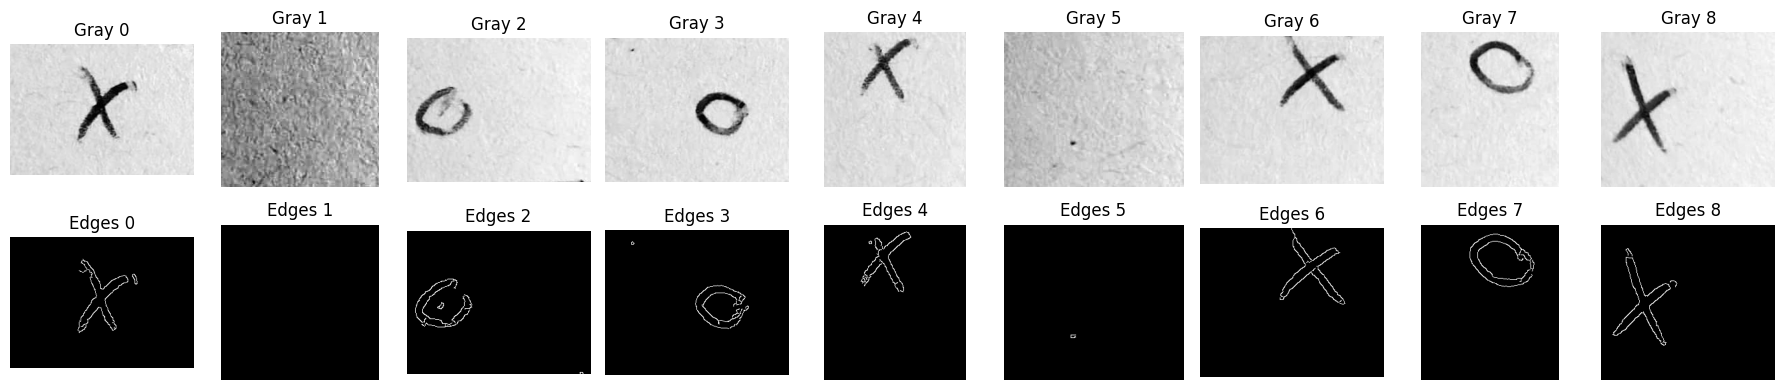

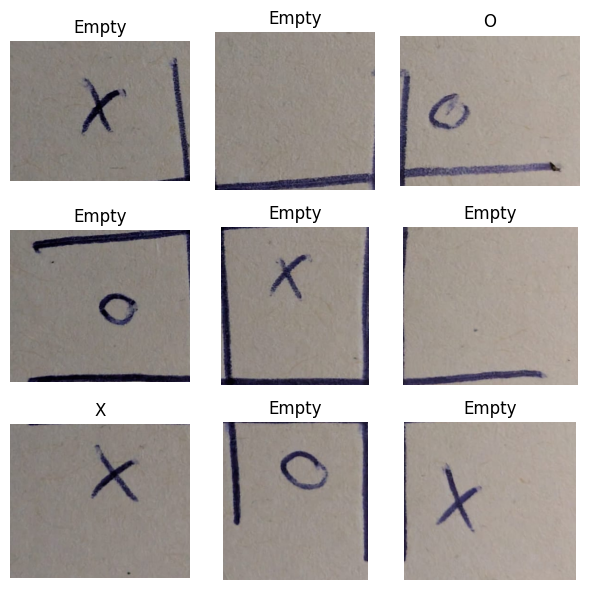

In [46]:
def preprocess(img, border_frac=0.15):
    # 1) Breite Streifen am Rand weg (nur Zentrum behalten)
    h, w = img.shape[:2]
    b = int(min(h, w) * border_frac)
    inner = img[b:h-b, b:w-b]

    # 2) Graustufen + Weichzeichnen
    gray = cv2.cvtColor(inner, cv2.COLOR_BGR2GRAY)
    blur = cv2.GaussianBlur(gray, (5,5), 0)

    # 3) Canny-Kanten
    edges = cv2.Canny(blur, 50, 150, apertureSize=3)

    # 4) Dicke horizontale & vertikale Linien extrahieren
    #    Kernel-Länge grob 1/8 der Feldgröße
    k_len = max(3, w // 8)
    ker_h = cv2.getStructuringElement(cv2.MORPH_RECT, (k_len, 1))
    ker_v = cv2.getStructuringElement(cv2.MORPH_RECT, (1, k_len))

    hori = cv2.morphologyEx(edges, cv2.MORPH_OPEN, ker_h)
    vert = cv2.morphologyEx(edges, cv2.MORPH_OPEN, ker_v)

    # 5) Grid-Maske & saubere Kanten
    grid_mask = cv2.bitwise_or(hori, vert)
    edges_clean = cv2.bitwise_and(edges, cv2.bitwise_not(grid_mask))

    return gray, edges_clean


def detect_X(edges):
    """
    HoughLines im Polarkoordinaten-Modus: wir suchen Mindestens 1 Linie
    um 45° und 1 Linie um 135° (±10° Toleranz).
    """
    lines = cv2.HoughLines(edges, 1, np.pi/180, threshold=50)
    if lines is None:
        return False
    thetas = np.degrees([l[0][1] for l in lines])  # in Grad
    band = 10
    c45  = np.sum((thetas>45-band)&(thetas<45+band))
    c135 = np.sum((thetas>135-band)&(thetas<135+band))
    return (c45>=1 and c135>=1)

def detect_O(gray, dp=1.0, min_dist_factor=0.5, param1=100, param2=20, r_min=0.2, r_max=0.5):
    """
    HoughCircles: param2 niedrig genug, um handgemalte O's zu finden.
    """
    h, w = gray.shape
    circles = cv2.HoughCircles(
        gray, cv2.HOUGH_GRADIENT,
        dp=dp,
        minDist=int(min(h,w)*min_dist_factor),
        param1=param1,
        param2=param2,
        minRadius=int(min(h,w)*r_min),
        maxRadius=int(min(h,w)*r_max)
    )
    return circles is not None and len(circles[0])>=1

def classify_cell(img):
    """
    Erst X prüfen, dann O, sonst Empty.
    """
    gray, edges = preprocess(img)

    if detect_X(edges):
        return 'X'
    if detect_O(gray):
        return 'O'
    return 'Empty'


# --- Anwendung auf deine 9 Felder ---
results = []
for idx, feld in enumerate(field_bilder):
    klass = classify_cell(feld)
    results.append(klass)
    print(f"Field {idx}: {klass}")



# Visualisierung
pre_grays = []
pre_edges = []
for feld in field_bilder:
    gray, edges = preprocess(feld, border_frac=0.15)
    pre_grays.append(gray)
    pre_edges.append(edges)

# 2) Anzeigen: oben Graustufen, unten Kanten
fig, axes = plt.subplots(2, 9, figsize=(18, 4))
for i in range(9):
    ax1 = axes[0, i]
    ax2 = axes[1, i]

    ax1.imshow(pre_grays[i], cmap='gray')
    ax1.set_title(f"Gray {i}")
    ax1.axis('off')

    ax2.imshow(pre_edges[i], cmap='gray')
    ax2.set_title(f"Edges {i}")
    ax2.axis('off')

plt.tight_layout()
plt.show()

# Visualisierung
fig, axes = plt.subplots(3,3, figsize=(6,6))
for (row,col), feld, klass in zip(positionen, field_bilder, results):
    ax = axes[row,col]
    ax.imshow(cv2.cvtColor(feld, cv2.COLOR_BGR2RGB))
    ax.set_title(klass)
    ax.axis('off')
plt.tight_layout()
plt.show()


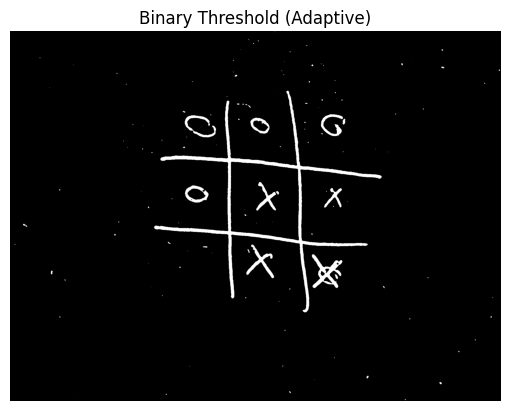

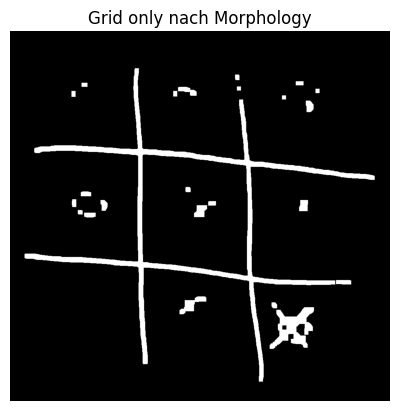

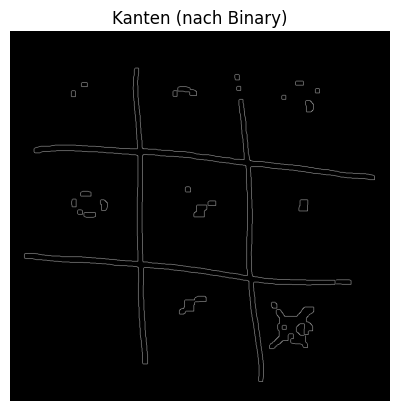

Gefundene Linien (roh): 195
Gefundene Linien (gefiltert): 12


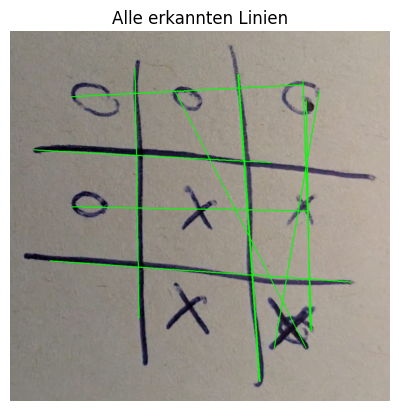

x-Koordinaten (ungeclustert): [642, 641, 640, 769, 797, 340, 800]
x-Koordinaten (geclustert): [340, 641, 788]
y-Koordinaten (ungeclustert): [645, 336, 477, 160]
y-Koordinaten (geclustert): [160, 336, 477, 645]


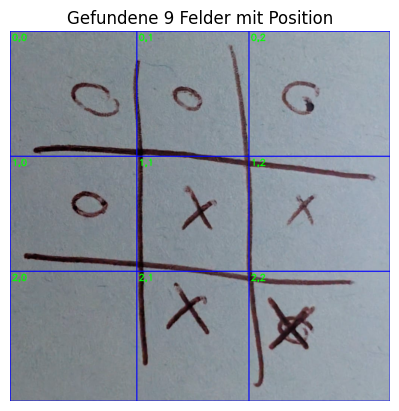

Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 338
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 439
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 442
Angle difference is not ~90°: [np.float64(28.609756097561046), np.float64(90.50000000000006)]
Line Score: False, Circle Score: 567
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 99
Angle difference is not ~90°: [np.float64(86.06382978723406), np.float64(98.10169491525424)]
Line Score: False, Circle Score: 438
Too much angle variety: 3 clusters explain better than 2.
Line Score: False, Circle Score: 379
Image is messy: 3 clusters explain better than 2 but further analysis needed.
Angle difference is not ~90°: [np.float64(4.960000000000122), np.float64(175.37078651685408)]
Line Score: False, Circle Score: 490
Too much angle variety: 3 clusters explain better than 2

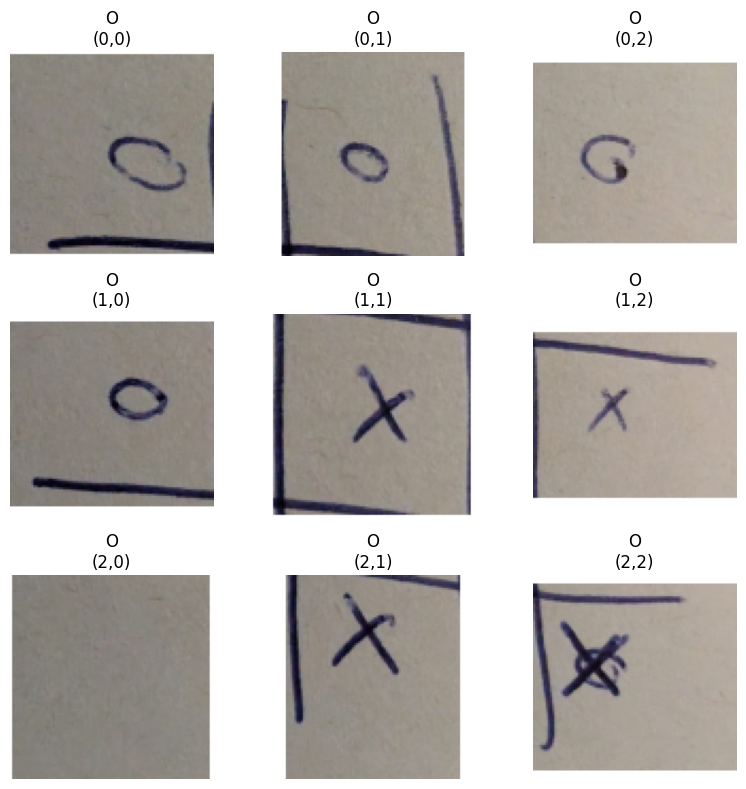

In [3]:
def to_grayscale_and_binary(img, size=96):
    # In Graustufen und binär umwandeln, falls nötig
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Wieder adaptive threshold (wie oben)
    binary = cv2.adaptiveThreshold(
        gray,
        maxValue=255,
        adaptiveMethod=cv2.ADAPTIVE_THRESH_GAUSSIAN_C,
        thresholdType=cv2.THRESH_BINARY_INV,
        blockSize=51,
        C=7
    )
    # Auf gewünschte Größe bringen, falls nötig (macht crop_and_resize_field aber meist schon)
    return cv2.resize(binary, (size, size), interpolation=cv2.INTER_AREA)

def show_9_classified_fields(field_bilder, positionen, size=96):
    if not field_bilder or not positionen:
        print("Keine Felder zum Anzeigen!")
        return
    fig, axs = plt.subplots(3, 3, figsize=(8, 8))
    for idx, (feld, pos) in enumerate(zip(field_bilder, positionen)):
        row, col = pos
        # Normiertes Feld erzeugen (wie bisher)
        norm_feld = crop_and_resize_field(feld, size=size)
        # Binärbild für Klassifikation erzeugen
        bin_feld = to_grayscale_and_binary(norm_feld, size=size)
        # Klassifikation durchführen
        label = classify_cell(bin_feld)
        axs[row, col].imshow(cv2.cvtColor(norm_feld, cv2.COLOR_BGR2RGB))
        axs[row, col].set_title(f"{label}\n({row},{col})")
        axs[row, col].axis('off')
    plt.tight_layout()
    plt.show()

# Beispiel-Aufruf für Klassifikation + Anzeige:
# ---- Muss nach Teil 1 und 2 ausgeführt werden ----
field_bilder, positionen = detect_tic_tac_toe_grid('Filled_Field1.png')
show_9_classified_fields(field_bilder, positionen, size=96)